<a href="https://colab.research.google.com/github/mugsiemx/deep-learning-challenge/blob/main/Charity_Funding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
# import the repository for the csv file
! git clone https://github.com/mugsiemx/deep-learning-challenge

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

# #  Import and read the charity_data.csv.
# import pandas as pd 
# application_df = pd.read_csv("/Resources/charity_data.csv")
# application_df.head()

# read the CSV file from the Resources folder into a dask DataFrame
## change the data types to strings and integers
%time df = dd.read_csv('/content/deep-learning-challenge/Resources/charity_data.csv', low_memory=False,\
                       dtype={'APPLICATION_TYPE': 'string','AFFILIATION': 'string','CLASSIFICATION': 'string',\
                              'USE_CASE': 'string','ORGANIZATION': 'string','STATUS': 'int','INCOME_AMT': 'string',\
                              'SPECIAL_CONSIDERATIONS': 'string'}\
                       )
# review the DataFrame
df.dtypes, df.shape

CPU times: user 8.76 ms, sys: 8.82 ms, total: 17.6 ms
Wall time: 17.6 ms


(EIN                        int64
 NAME                      object
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object,
 (Delayed('int-e01fe2bd-9771-42b4-9e25-f20b7df7d4aa'), 12))

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
df = df.drop(['EIN','NAME'], axis=1)

# dropping non-productive column(s)
df = df.drop(['INCOME_AMT', 'SPECIAL_CONSIDERATIONS'], axis=1)

df.info(), df.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, APPLICATION_TYPE to IS_SUCCESSFUL
dtypes: int64(3), string(5)

(None,
 APPLICATION_TYPE    string
 AFFILIATION         string
 CLASSIFICATION      string
 USE_CASE            string
 ORGANIZATION        string
 STATUS               int64
 ASK_AMT              int64
 IS_SUCCESSFUL        int64
 dtype: object)

In [4]:
# create DataFrame with compute
application_df = df.compute()
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,142590,1
...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,5000,1


In [5]:
# missing data
# application_df.isnull

In [6]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE      17
AFFILIATION            6
CLASSIFICATION        71
USE_CASE               5
ORGANIZATION           4
STATUS                 2
ASK_AMT             8747
IS_SUCCESSFUL          2
dtype: int64

In [7]:
# Look at APPLICATION_TYPE value counts for binning
app_counts = application_df['APPLICATION_TYPE'].value_counts()
app_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: Int64

In [8]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
application_types_to_replace = app_counts[app_counts < 500].index.values
    
# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: Int64

In [9]:
# Look at CLASSIFICATION value counts for binning
class_counts = application_df['CLASSIFICATION'].value_counts()
class_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C5200        1
C2600        1
C4200        1
C2190        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: Int64

In [10]:
# You may find it helpful to look at CLASSIFICATION value counts >1
# listed all counts for counts in number of classifications for each classification (1000 is our 'Other' bin point)
c = ((application_df['CLASSIFICATION'].value_counts()).value_counts().sort_values(ascending=False))
c

1        26
2         5
3         3
6         3
32        2
5         2
9         2
10        2
15        2
194       1
104       1
114       1
116       1
1918      1
287       1
777       1
1883      1
75        1
4837      1
95        1
17326     1
58        1
50        1
36        1
6074      1
30        1
20        1
18        1
16        1
14        1
11        1
7         1
34        1
Name: CLASSIFICATION, dtype: Int64

In [11]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
classifications_to_replace = class_counts[class_counts < 1000].index.values

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: Int64

In [12]:
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,142590,1
...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,5000,1


In [13]:
# Convert categorical data to numeric with `pd.get_dummies`
clean_df = pd.get_dummies(application_df)
clean_df

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust
0,1,5000,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,1,108590,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,5000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
3,1,6692,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1,142590,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,1,5000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
34295,1,5000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
34296,1,5000,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
34297,1,5000,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0


In [14]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   STATUS                        34299 non-null  int64
 1   ASK_AMT                       34299 non-null  int64
 2   IS_SUCCESSFUL                 34299 non-null  int64
 3   APPLICATION_TYPE_Other        34299 non-null  uint8
 4   APPLICATION_TYPE_T10          34299 non-null  uint8
 5   APPLICATION_TYPE_T19          34299 non-null  uint8
 6   APPLICATION_TYPE_T3           34299 non-null  uint8
 7   APPLICATION_TYPE_T4           34299 non-null  uint8
 8   APPLICATION_TYPE_T5           34299 non-null  uint8
 9   APPLICATION_TYPE_T6           34299 non-null  uint8
 10  APPLICATION_TYPE_T7           34299 non-null  uint8
 11  APPLICATION_TYPE_T8           34299 non-null  uint8
 12  AFFILIATION_CompanySponsored  34299 non-null  uint8
 13  AFFILIATION_Family/Parent     3

In [25]:
# change to numeric values to view scatter plot correlations
scatter_df = clean_df.copy()
scatter_df = scatter_df.astype('int64')

scatter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   STATUS                        34299 non-null  int64
 1   ASK_AMT                       34299 non-null  int64
 2   IS_SUCCESSFUL                 34299 non-null  int64
 3   APPLICATION_TYPE_Other        34299 non-null  int64
 4   APPLICATION_TYPE_T10          34299 non-null  int64
 5   APPLICATION_TYPE_T19          34299 non-null  int64
 6   APPLICATION_TYPE_T3           34299 non-null  int64
 7   APPLICATION_TYPE_T4           34299 non-null  int64
 8   APPLICATION_TYPE_T5           34299 non-null  int64
 9   APPLICATION_TYPE_T6           34299 non-null  int64
 10  APPLICATION_TYPE_T7           34299 non-null  int64
 11  APPLICATION_TYPE_T8           34299 non-null  int64
 12  AFFILIATION_CompanySponsored  34299 non-null  int64
 13  AFFILIATION_Family/Parent     3

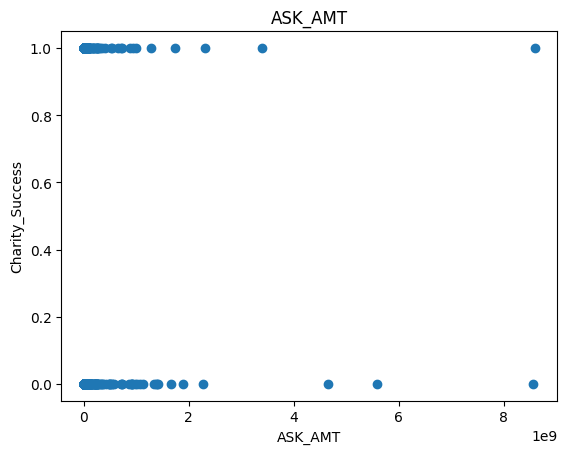

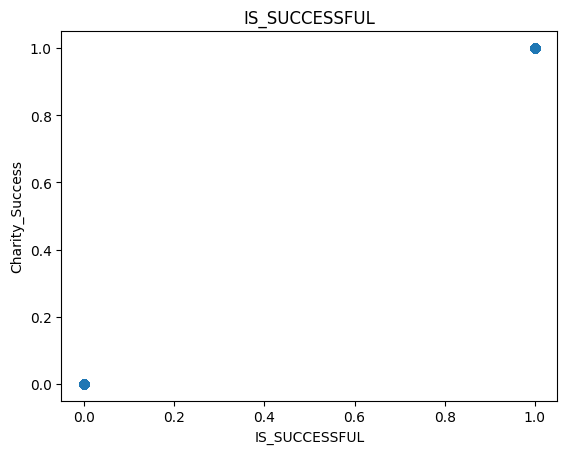

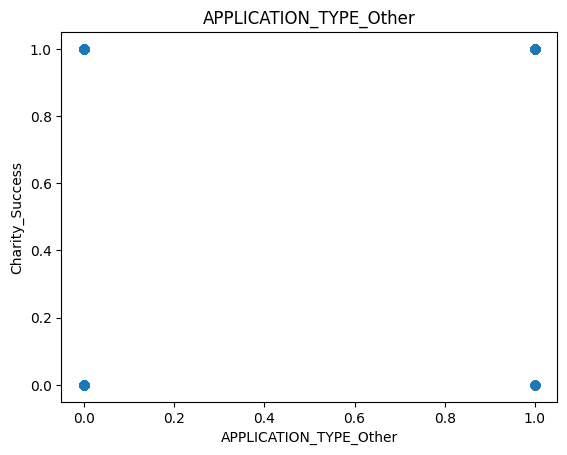

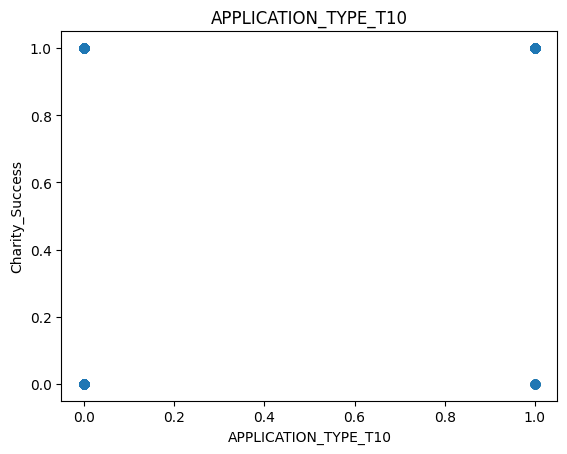

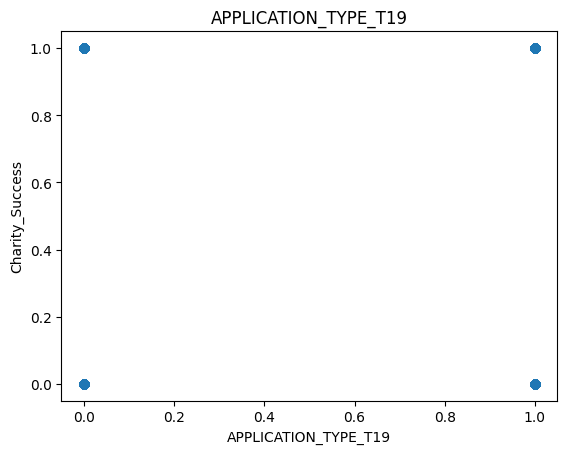

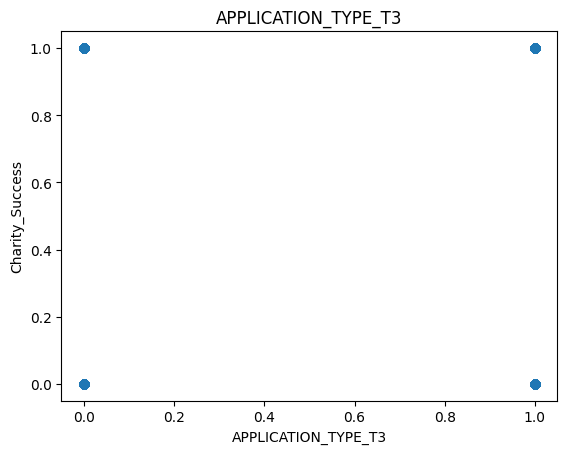

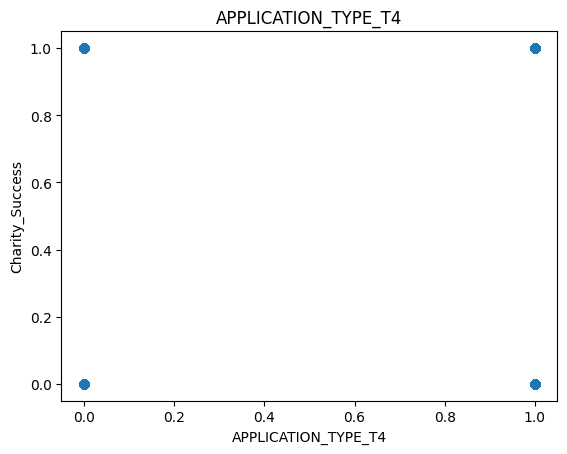

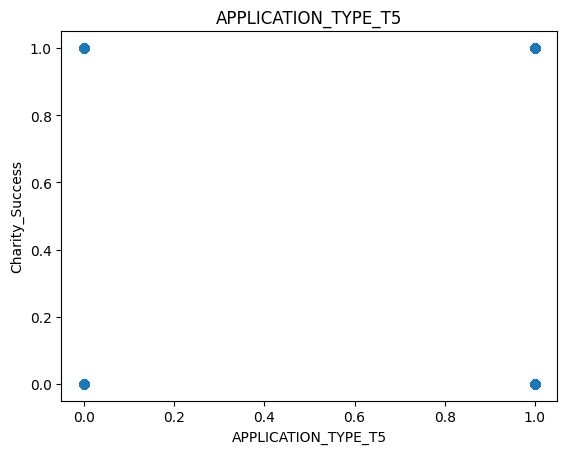

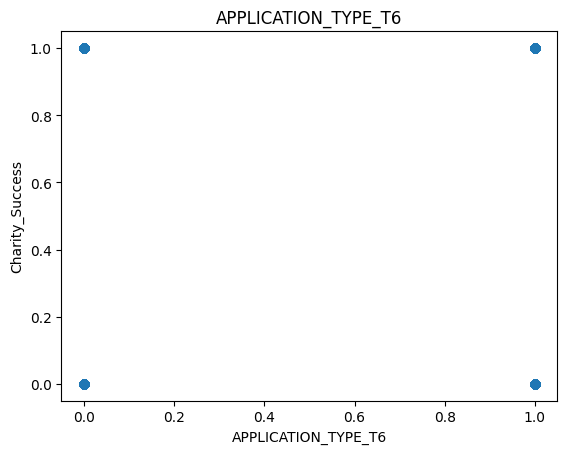

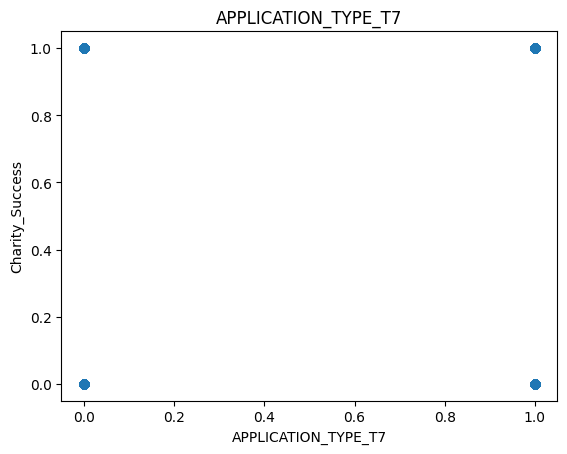

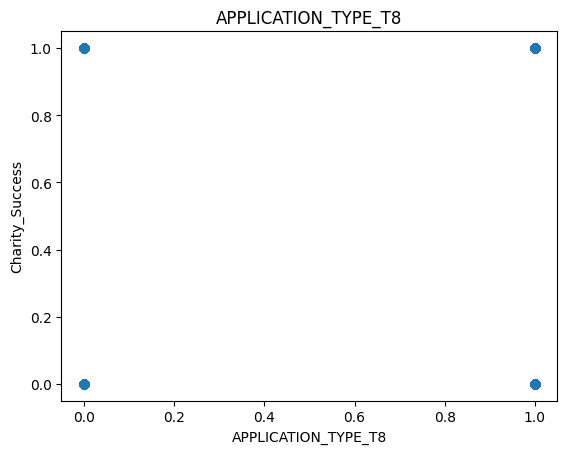

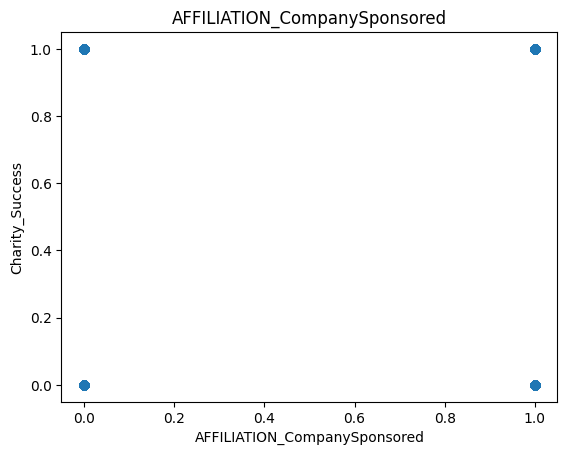

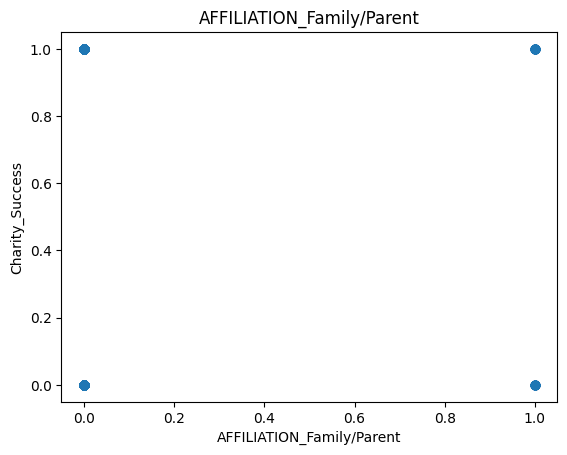

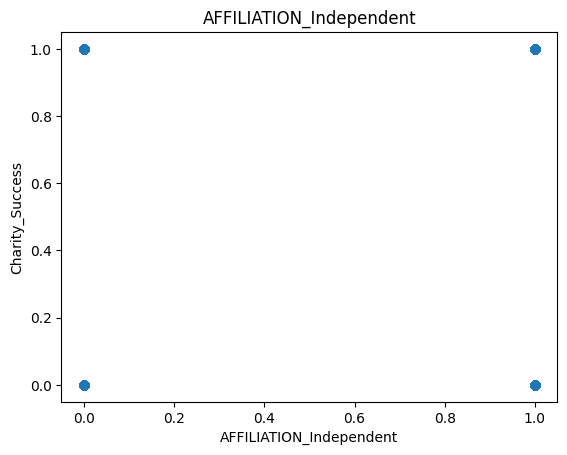

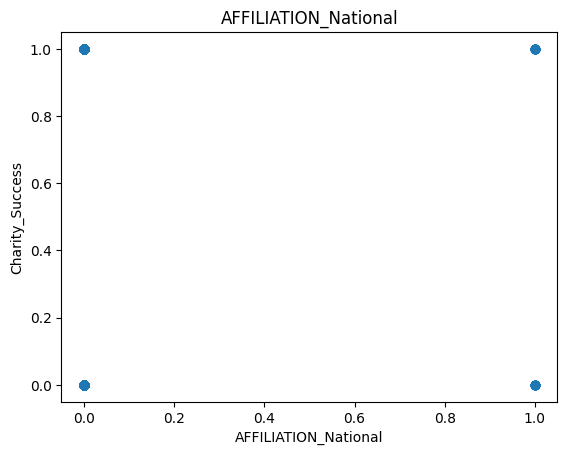

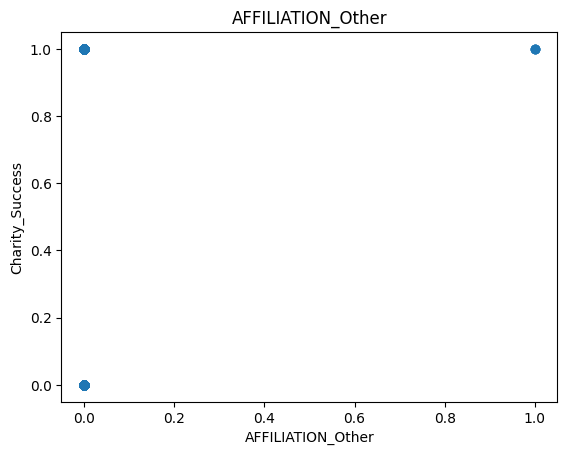

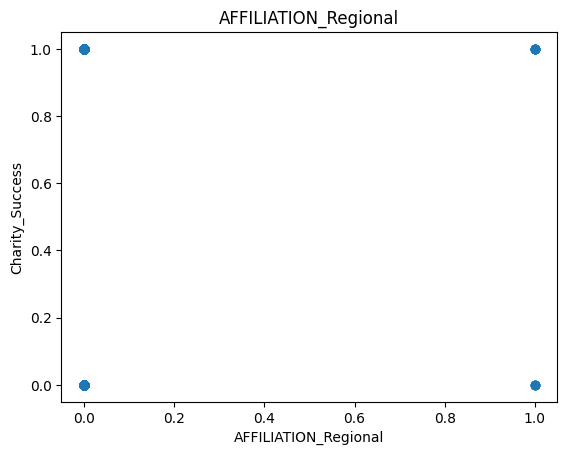

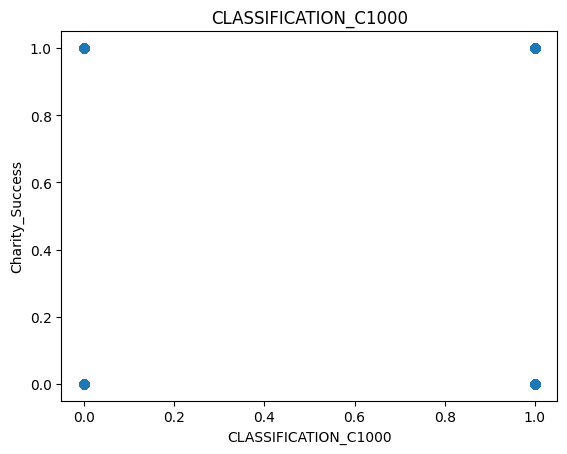

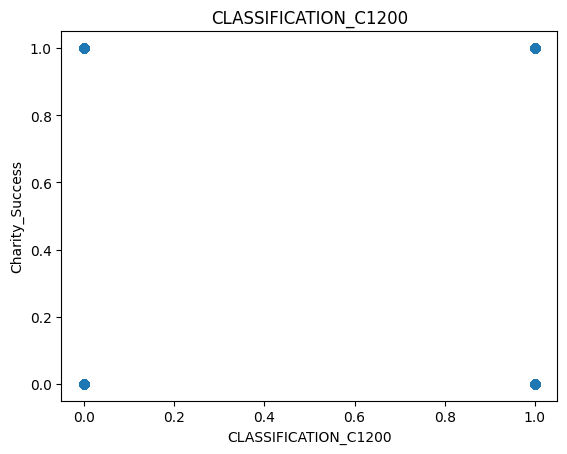

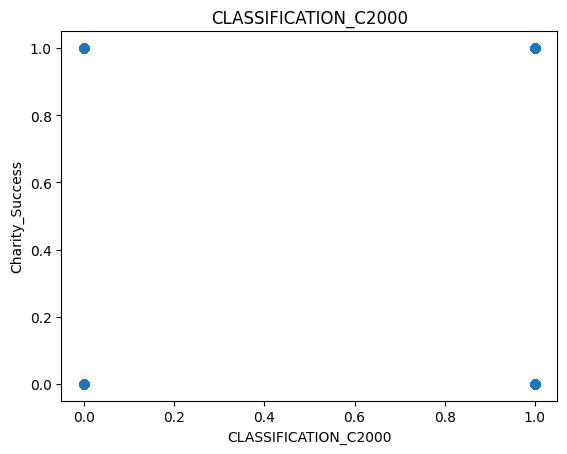

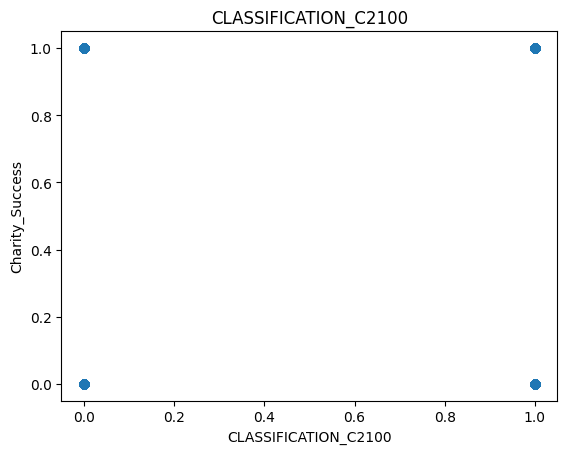

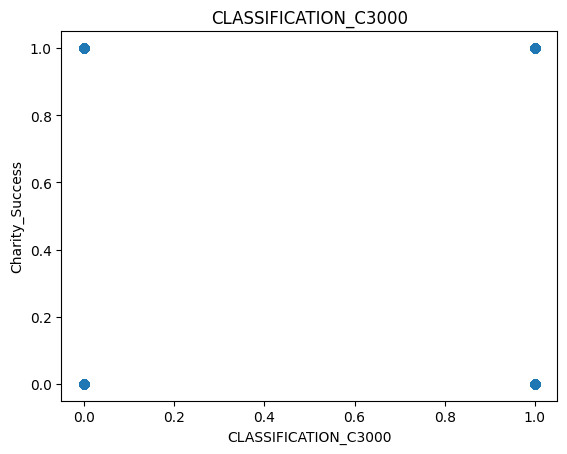

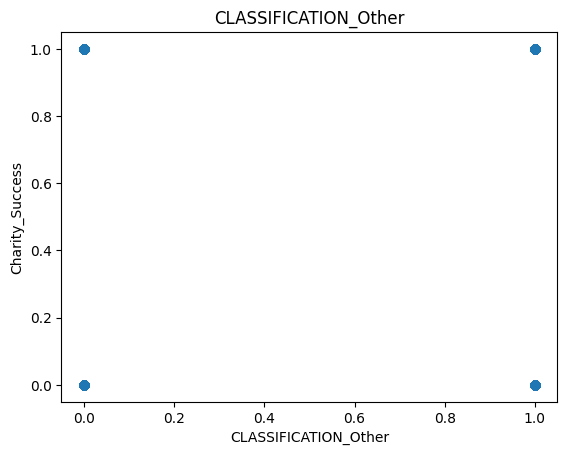

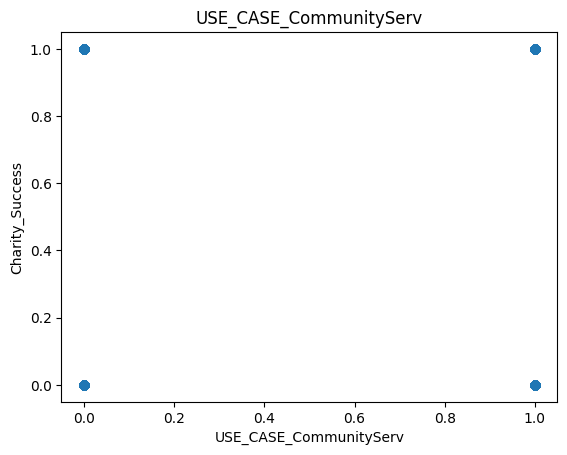

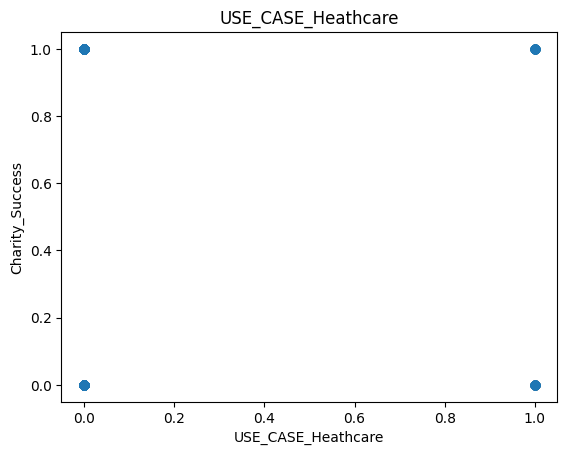

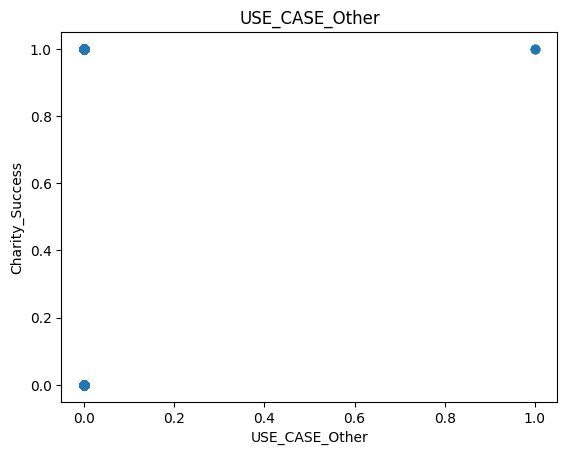

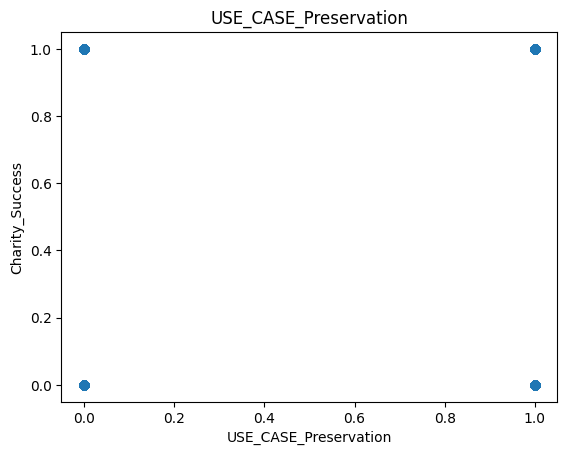

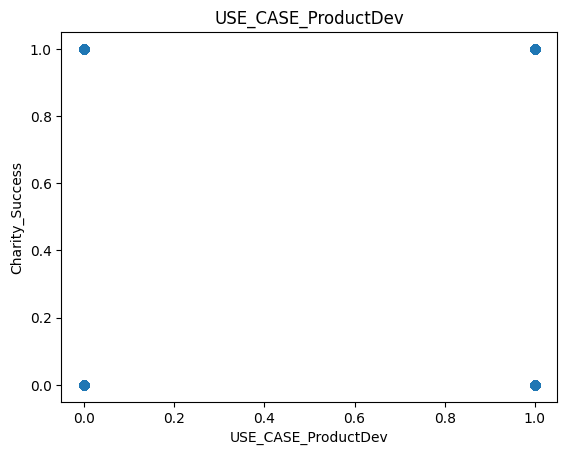

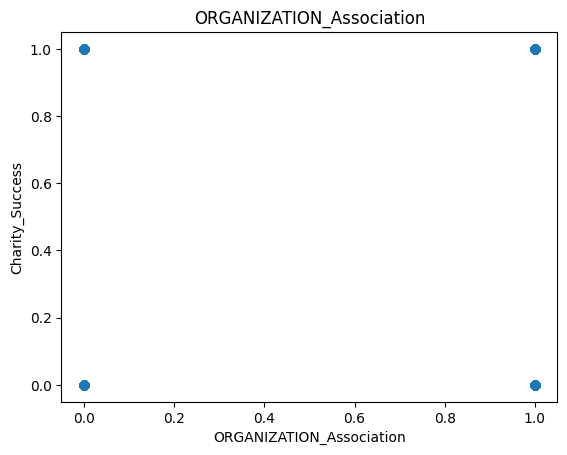

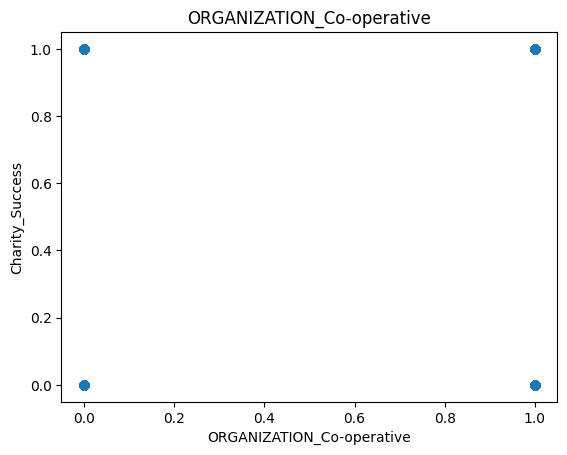

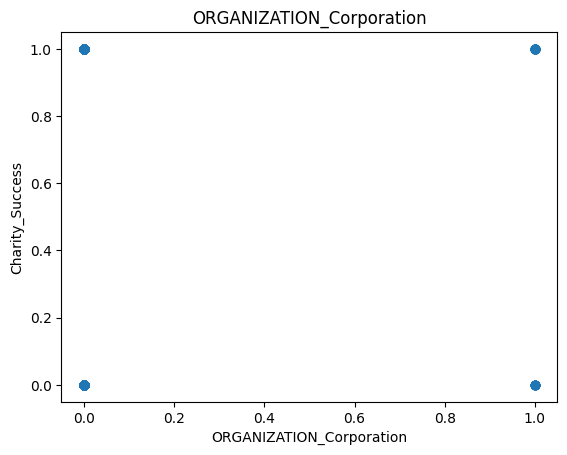

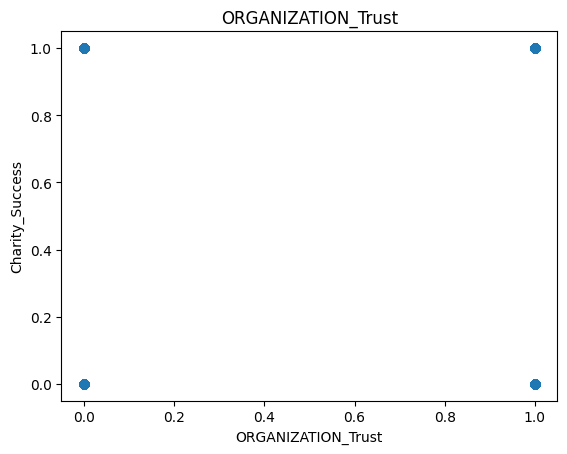

In [26]:
for label in scatter_df.columns[1:]:
  plt.scatter(scatter_df[label], scatter_df['IS_SUCCESSFUL'])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel('Charity_Success')
  plt.show()

In [15]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   STATUS                        34299 non-null  int64
 1   ASK_AMT                       34299 non-null  int64
 2   IS_SUCCESSFUL                 34299 non-null  int64
 3   APPLICATION_TYPE_Other        34299 non-null  uint8
 4   APPLICATION_TYPE_T10          34299 non-null  uint8
 5   APPLICATION_TYPE_T19          34299 non-null  uint8
 6   APPLICATION_TYPE_T3           34299 non-null  uint8
 7   APPLICATION_TYPE_T4           34299 non-null  uint8
 8   APPLICATION_TYPE_T5           34299 non-null  uint8
 9   APPLICATION_TYPE_T6           34299 non-null  uint8
 10  APPLICATION_TYPE_T7           34299 non-null  uint8
 11  APPLICATION_TYPE_T8           34299 non-null  uint8
 12  AFFILIATION_CompanySponsored  34299 non-null  uint8
 13  AFFILIATION_Family/Parent     3

In [16]:
# Split our preprocessed data into our features and target arrays
y = clean_df.IS_SUCCESSFUL.values
X = clean_df.drop(columns='IS_SUCCESSFUL').values

# Split the preprocessed data into a training and testing dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [17]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

In [18]:
# define variables for quick access to training
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30
epochs = 100

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                2800      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, verbose=0)

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5545 - accuracy: 0.7272 - 351ms/epoch - 1ms/step
Loss: 0.5544604063034058, Accuracy: 0.7272303104400635


In [23]:
# Export our model to HDF5 file
# fit_model.save("model_1st_good_run_.h5")
# keras.callbacks.ModelCheckpoint() # to save the best model